## Self-consistency 

Dual-polarization radar variables Zh, Zdr and Kdp are related. The self-consistency principle is used for absolute radar calibration and precipiation estimation. There is also a relation between path attenuation and Kdp.  This notebook illustrates these relations. 

Exercise
- test how the relation between Zh, Zdr and Kdp depends on DSD parameters (especially mu) and the raindrop shape model
- test how A_Kdp relation depends on temperature, DSD parameters, and the raindrop shape model
- select a different radar wavlength (S, or X -band)


In [2]:
from matplotlib import pyplot as plt
from numpy.random import normal
import numpy as np

from pytmatrix.tmatrix import Scatterer
from pytmatrix.psd import PSDIntegrator, GammaPSD
from pytmatrix import orientation, radar, tmatrix_aux, refractive
%matplotlib inline

### Raindrop shapes
Different raindrop axis ratios are used in the literature. Some of them are defined in tmatrix_aux.

Beard and Chuang (1987) equilibrium  model axis ratio

    b/a = 1.0048 + 5.7e-4*D - 2.628e-2*D^2 + 3.682e-3*D^3 - 1.677e-4*D^4 

Thurai et al. raindrop axis ratio - fit to 2D-video measured raindrop shape

    b/a = 1, D_eq < 0.7

    b/a = 1.173 - 0.5165*D + 0.4698*D^2 - 0.1317*D^3 - 8.5e-3*D^4, 0.7>= D < 1.5

    b/a =  1.065 - 6.25e-2*D - 3.99e-3*D^2 + 7.66e-4*D^3 - 4.095e-5*D^4, D >=1.5 

Pruppacher and Beard (1970) axis ratio - fit to windtunnel data

    b/a = 1.03 - 0.062*D

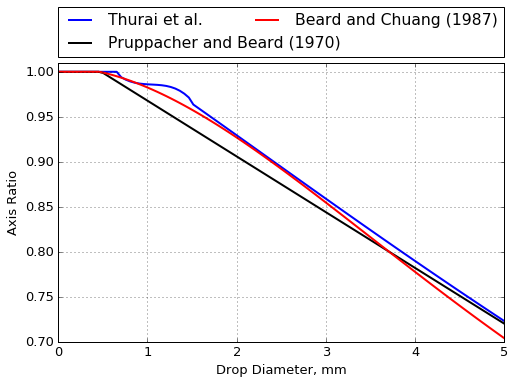

In [19]:
# The axis ratios shown above are also defined in tmatrix_aux, so we are not using the above definitions
# But you can if you want
D = np.linspace(0.0,5.0,100) # raindrop diameter in mm
ar_th = np.zeros(D.shape)
ar_bc = np.zeros(D.shape)
ar_pb = np.zeros(D.shape)

for indx in range(0,len(D)):
    ar_th[indx] = tmatrix_aux.dsr_thurai_2007(D[indx])
    ar_bc[indx] = tmatrix_aux.dsr_bc(D[indx])
    ar_pb[indx] = tmatrix_aux.dsr_pb(D[indx])

ar_pb = ar_pb.clip(min=None, max=1.0) # limiting the axis ratio to 1
ar_bc = ar_bc.clip(min=None, max=1.0) # limiting the axis ratio to 1

plots=[]
fig = plt.figure(figsize=[8,5])
font = {'size': 13}
plt.rc('font',**font)
plt.plot(D,ar_th, linestyle='-', color='b', linewidth=2.0, label="Thurai et al.")
plt.plot(D,ar_pb, linestyle='-', color='k', linewidth=2.0,  label="Pruppacher and Beard (1970)")
plt.plot(D,ar_bc, linestyle='-', color='r', linewidth=2.0,  label="Beard and Chuang (1987)")
plt.xlabel("Drop Diameter, mm")
plt.ylabel("Axis Ratio")

plt.gca().set_xlim([0.0,5.0])
plt.gca().set_ylim([0.7,1.01]) 
plt.grid(True)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

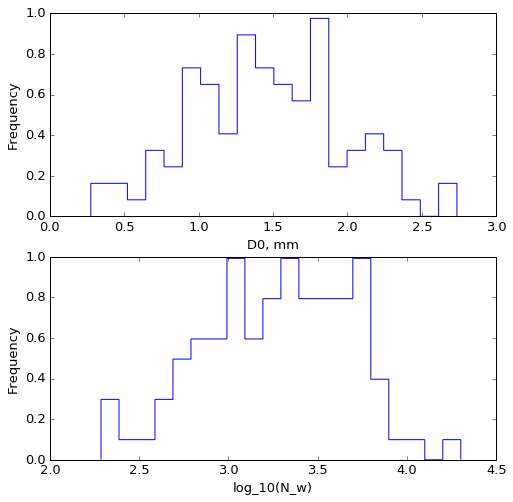

In [30]:
# DSD parameters
# assuming that DSD follows normalized Gamma functional form (see eq. 7.62, Bringi and Chandrasekar, 2001)
# number of simulated DSDs
ndsd = 100

mu = 6.0 # shape parameter of DSD, typically assumed to be 3, but in Europe seems to be closer to 5-6

# D0 distribution is rather narrow and centered around 0.8 mm
D0=.5*normal(size=ndsd) + 1.5

# log10(Nw) is also distributed normally
Nw=10**(.4*normal(size=ndsd) + np.log10(2000))

# rejecting DSDs that have too low D0 and N_w
Nw= Nw[D0>0.2]
D0= D0[D0>0.2]
D0= D0[Nw>100]
Nw= Nw[Nw>100]


# visualizing DSD parameter distributions
plots=[]
fig = plt.figure(figsize=[8,8])
font = {'size': 13}
plt.subplot(2, 1, 1) 
plt.hist(D0,20, normed=True, cumulative=False, histtype='step')
plt.xlabel("D0, mm")
plt.ylabel("Frequency")

plt.subplot(2, 1, 2) 
plt.hist(np.log10(Nw),20, normed=True, cumulative=False, histtype='step')
plt.xlabel("log_10(N_w)")
plt.ylabel("Frequency")
plt.show()

In [32]:
# Computing dual-polarization radar variables
z   = np.zeros([ndsd,1]) # reflectivity factor mm^6 m^-3
zdr = np.zeros([ndsd,1]) # differential reflectivity
kdp = np.zeros([ndsd,1]) # deg / km

# Specific attenuation dB/km
A=np.zeros([ndsd,1])

for indx in range(0,ndsd):
        # selecting the wavelength and refractive index of water, which depends on temperature
        # the unit of the wavelength defines units of raindrop single scattering properties, i.e. radar crosssection
        # for computations of radar variables needs to be in mm
        scatterer = Scatterer(wavelength=tmatrix_aux.wl_C, m=refractive.m_w_10C[tmatrix_aux.wl_C])
        scatterer.psd_integrator = PSDIntegrator()
        scatterer.psd_integrator.axis_ratio_func = lambda D: 1.0/tmatrix_aux.dsr_thurai_2007(D)
        scatterer.psd_integrator.D_max = 2.5 * D0[indx] # maximum diameter used for DSD integration
        
        # defining raindrop orientations 0 elevation angle and 7 deg std of the canting angle distributions
        scatterer.or_pdf = orientation.gaussian_pdf(7.0, 0.0)
        scatterer.orient = orientation.orient_averaged_fixed
        
        scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
        scatterer.psd_integrator.init_scatter_table(scatterer)
        scatterer.psd = GammaPSD(D0=D0[indx], Nw=Nw[indx], mu=mu)
        
        scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
        zdr[indx] =radar.Zdr(scatterer)
        z[indx]   =radar.refl(scatterer)
        
        # forward scattering geometery needs to be selected for Kdp and specific attenuation calculations
        scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
        kdp[indx] =radar.Kdp(scatterer)
        A[indx]   =radar.Ai(scatterer)

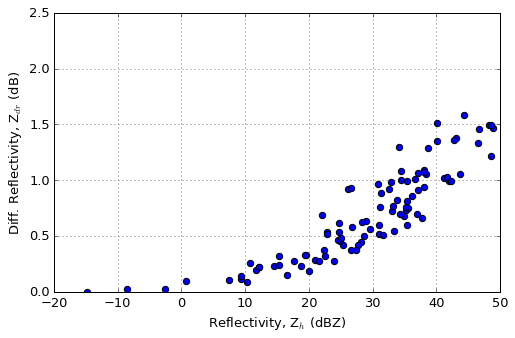

In [33]:
# Differential reflectivity and reflectivity factor
plots=[]
fig = plt.figure(figsize=[8,5])
font = {'size': 13}
plt.scatter(10.0*np.log10(z), 10.0*np.log10(zdr), s=40)
plt.xlabel('Reflectivity, Z$_{h}$ (dBZ)')
plt.ylabel('Diff. Reflectivity, Z$_{dr}$ (dB)')
plt.gca().set_ylim([0.0,2.5])
plt.gca().set_xlim([-20.0,50.0]) 
plt.grid(True)
plt.show()

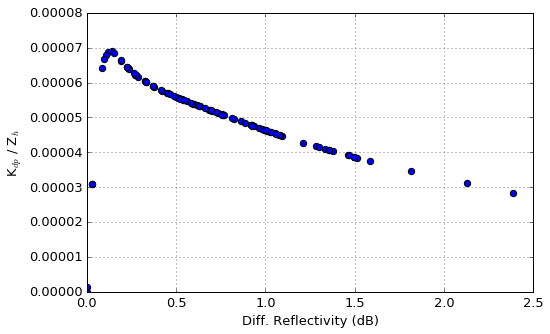

In [34]:
# Consistency curve relating Kdp, Zh, and Zdr 
# You may want to change mu and raindrop shape model and test how it affects the curve
plots=[]
fig = plt.figure(figsize=[8,5])
plt.scatter(10.0*np.log10(zdr), kdp/z, s=40)

plt.gca().set_ylim([0.0,8e-5])
plt.gca().set_xlim([0.0,2.5]) 
plt.grid(True)
plt.ylabel('K$_{dp}$ / Z$_{h}$')
plt.xlabel('Diff. Reflectivity (dB)')
plt.show()

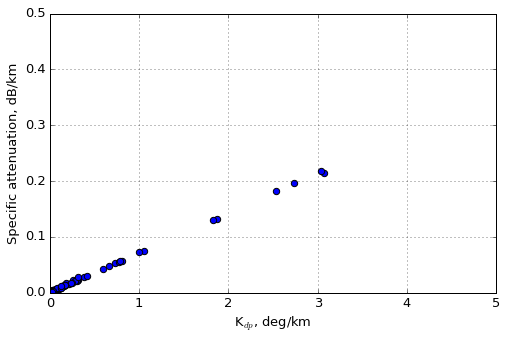

In [40]:
# The relation between specific attenuation and K_dp
plots=[]
fig = plt.figure(figsize=[8,5])
plt.scatter(kdp, A, s=40)

plt.gca().set_ylim([0.0,0.5])
plt.gca().set_xlim([0.0,5.0]) 
plt.grid(True)
plt.xlabel('K$_{dp}$, deg/km ')
plt.ylabel('Specific attenuation, dB/km')
plt.show()